# Deblending

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from scipy.sparse.linalg import lobpcg as sp_lobpcg
from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import fista

In [2]:
###############################################################################
# Let's start by defining a blending operator
def Blending(nt, ns, dt, overlap, times, dtype="float64"):
    """Blending operator"""
    pad = int(overlap * nt)
    OpShiftPad = []
    for i in range(ns):
        PadOp = Pad(nt, (pad * i, pad * (ns - 1 - i)), dtype=dtype)
        ShiftOp = Shift(
            pad * (ns - 1) + nt, times[i], axis=0, sampling=dt, real=False, dtype=dtype
        )
        OpShiftPad.append(ShiftOp * PadOp)
    return HStack(OpShiftPad)

In [3]:
class GroupBlending(LinearOperator):
    """Group operator"""
    def __init__(self, nt, ns, dt, group_size, n_groups, times, dtype='float64'):
        self.dtype = np.dtype(dtype)
        self.explicit = False
        self.nt = nt
        self.ns = ns
        self.group_size = group_size
        self.n_groups = n_groups
        self.shape = (self.n_groups*self.nt, self.ns*self.nt)
        self.dt = dt
        self.times = times
        self.OpShifts = []
        for i in range(n_groups):
            for j in range (group_size):
                self.OpShifts.append(pylops.signalprocessing.Shift(self.nt, -self.times[i*group_size + j], dir=0, 
                                                                   sampling=self.dt, real=False, dtype=dtype))
    
    def _matvec(self, x):
        x = x.reshape(self.ns, self.nt)
        blended_data = np.zeros((self.n_groups, self.nt), dtype=self.dtype)
        for i in range(self.n_groups):
            # shift n sources and sum them together
            shifted_signal = np.zeros(self.nt, dtype=self.dtype)
            for j in range(self.group_size):
                shot = x[i * self.group_size + j].T
                shifted_signal = self.OpShifts[i * self.group_size + j] * shot.ravel() + shifted_signal
            blended_data[i] = shifted_signal
        return blended_data.ravel()
        
    def _rmatvec(self, x):
        x = x.reshape(self.n_groups, self.nt)
        deblended_data = np.zeros((self.ns, self.nt), dtype=self.dtype)
        for i in range(self.n_groups):
            # shift n sources and sum them together
            shifted_signal = np.zeros(self.nt, dtype=self.dtype)
            shot = x[i].T
            for j in range(self.group_size):
                shifted_signal = self.OpShifts[i * self.group_size + j].H * shot.ravel()
                deblended_data[i * self.group_size + j] = shifted_signal
        return deblended_data.ravel()


To start, let's see how we can find D=B B^H (sum of sources at each step)

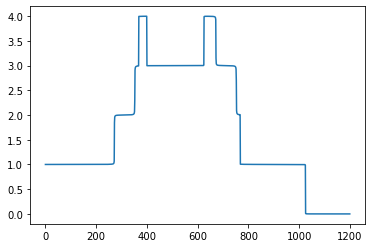

In [4]:
# Compute D
ns = 5
nt = 400
dt = 0.004
overlap = 0.5
pad = int(overlap * nt)
ignition_times = 2.0 * np.random.rand(ns) - 1.0
ignition_times[0] = 0.
Bop = Blending(nt, ns, dt, overlap, ignition_times, dtype="complex128")

D = (Bop @ Bop.H).todense()
plt.plot(np.diag(D.real));

Load the data

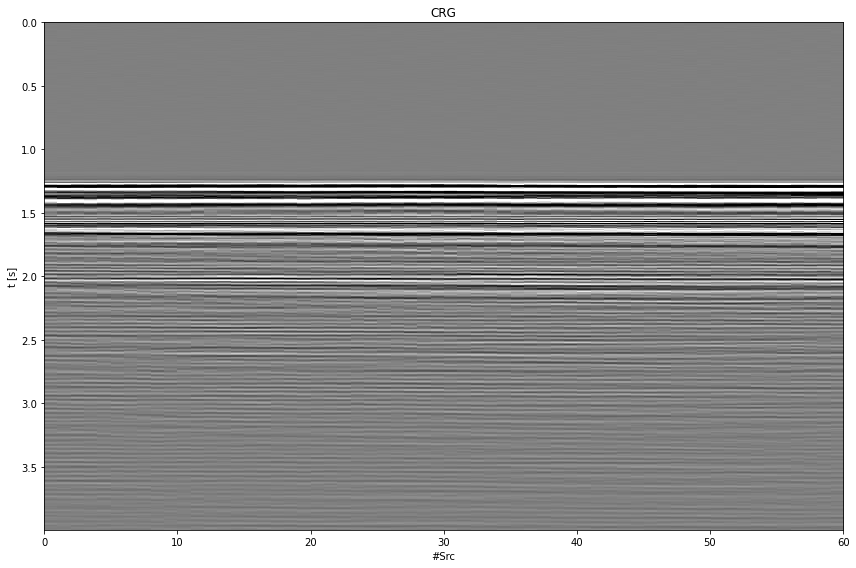

In [5]:
data = np.load("../../pylops/testdata/deblending/mobil.npy")
ns, nt = data.shape

dt = 0.004
t = np.arange(nt) * dt

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data.T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout();

## Continuous blending

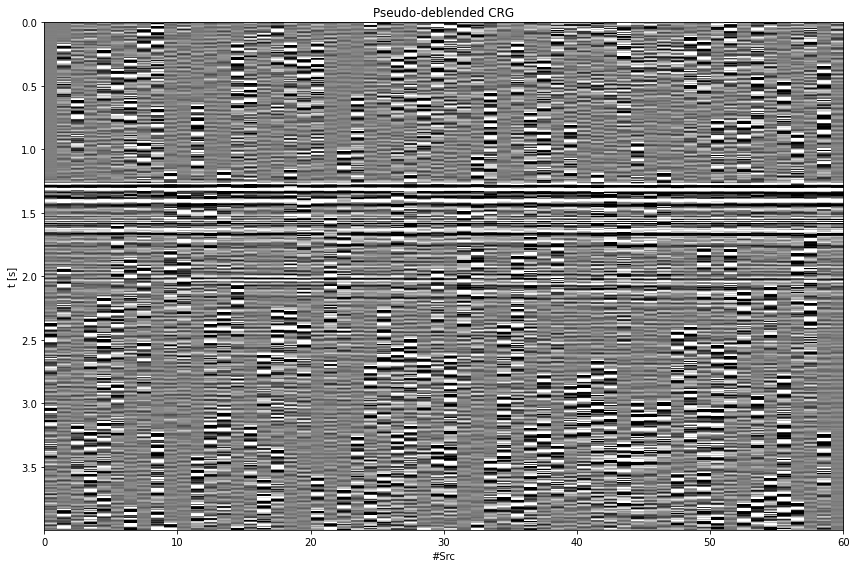

In [6]:
overlap = 0.25
pad = int(overlap * nt)
ignition_times = 2.0 * np.random.rand(ns) - 1.0
Bop = Blending(nt, ns, dt, overlap, ignition_times, dtype="complex128")
data_blended = Bop * data.ravel()
data_pseudo = Bop.H * data_blended.ravel()
data_pseudo = data_pseudo.reshape(ns, nt)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 15750 rows and 998400 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 60
alpha = 1.854449e-01	thresh = 4.636122e-01
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    3.018e+06   4.928e+06   1.026e+03
     2   -0.00e+00+0.00e+00j    1.502e+06   4.249e+06   5.128e+02
     3   -0.00e+00+0.00e+00j    7.746e+05   4.035e+06   3.868e+02
     4   0.00e+00+0.00e+00j    4.501e+05   3.957e+06   2.848e+02
     5   0.00e+00+0.00e+00j    3.060e+05   3.879e+06   2.228e+02
     6   0.00e+00+0.00e+00j    2.385e+05   3.775e+06   1.933e+02
     7   0.00e+00+0.00e+00j    2.034e+05   3.658e+06   1.808e+02
     8   0.00e+00+0.00e+00j    1.817e+05   3.542e+06   1.743e+02
     9   0.00e+00+0.00e+00j    1.655e+05   3.436e+06   1.695e+02
    10   0.00e+00+0.

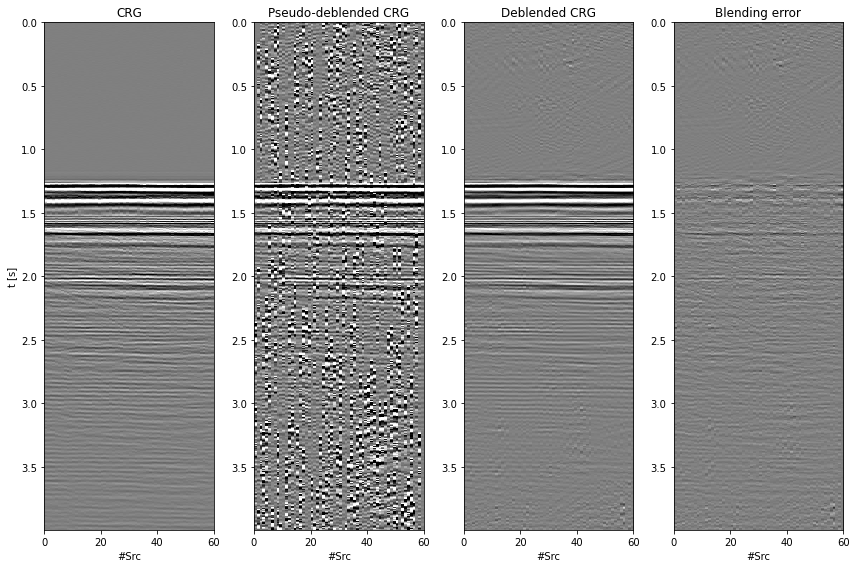

In [7]:
# Patched FK
dimsd = data.shape
nwin = (20, 80)
nover = (10, 40)
nop = (128, 128)
nop1 = (128, 65)
nwins = (5, 24)
dims = (nwins[0] * nop1[0], nwins[1] * nop1[1])

Fop = FFT2D(nwin, nffts=nop, real=True)
Sop = Patch2D(
    Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning", design=False
)
# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 60
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

with pylops.disabled_ndarray_multiplication():
    p_inv = fista(
        Op,
        data_blended.ravel(),
        niter=niter,
        eps=5e0,
        alpha=alpha,
        decay=decay,
        show=True,
    )[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data.T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

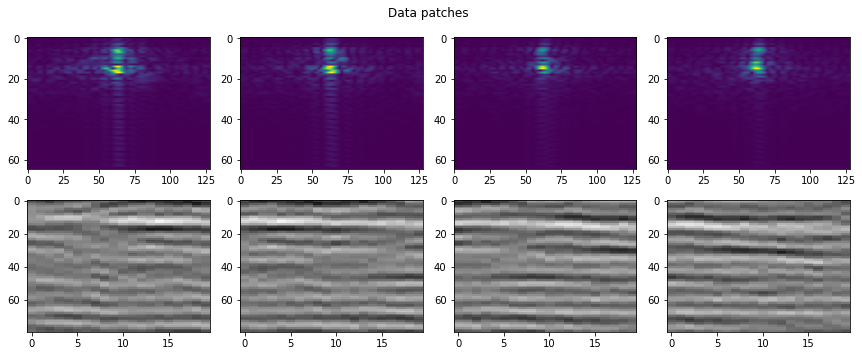

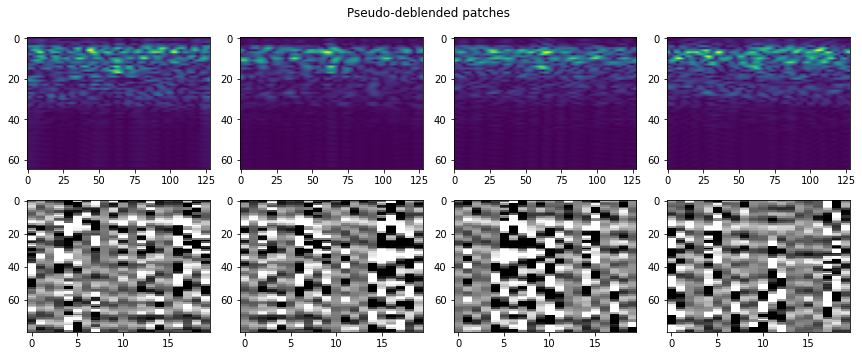

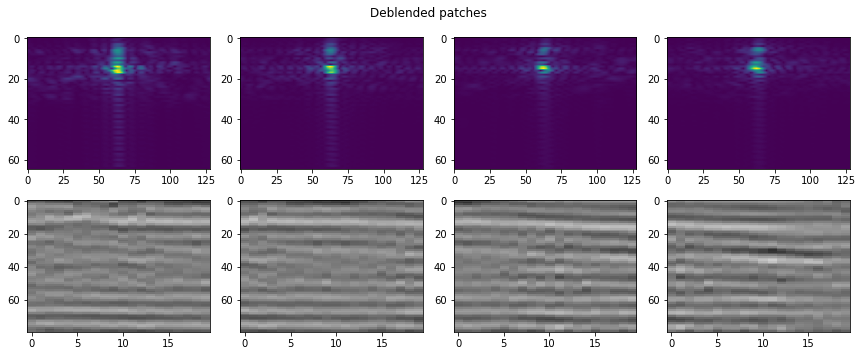

In [8]:
Sop1 = Patch2D(
    Fop.H, dims, dimsd, nwin, nover, nop1, tapertype=None, design=False
)

# Original
p = Sop1.H * data.ravel()
preshape = p.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

ix = 16
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
fig.suptitle("Data patches")
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(preshape[i, ix]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * preshape[i, ix].ravel()).reshape(nwin)).T,
        cmap="gray",
        vmin=-30,
        vmax=30,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Pseudo-deblended
p_pseudo = Sop1.H * data_pseudo.ravel()
p_pseudoreshape = p_pseudo.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

ix = 16
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
fig.suptitle("Pseudo-deblended patches")
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_pseudoreshape[i, ix]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_pseudoreshape[i, ix].ravel()).reshape(nwin)).T,
        cmap="gray",
        vmin=-30,
        vmax=30,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Deblended
p_inv = Sop1.H * data_inv.ravel()
p_invreshape = p_inv.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

ix = 16
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
fig.suptitle("Deblended patches")
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_invreshape[i, ix]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_invreshape[i, ix].ravel()).reshape(nwin)).T,
        cmap="gray",
        vmin=-30,
        vmax=30,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

## Group blending (2 sources)

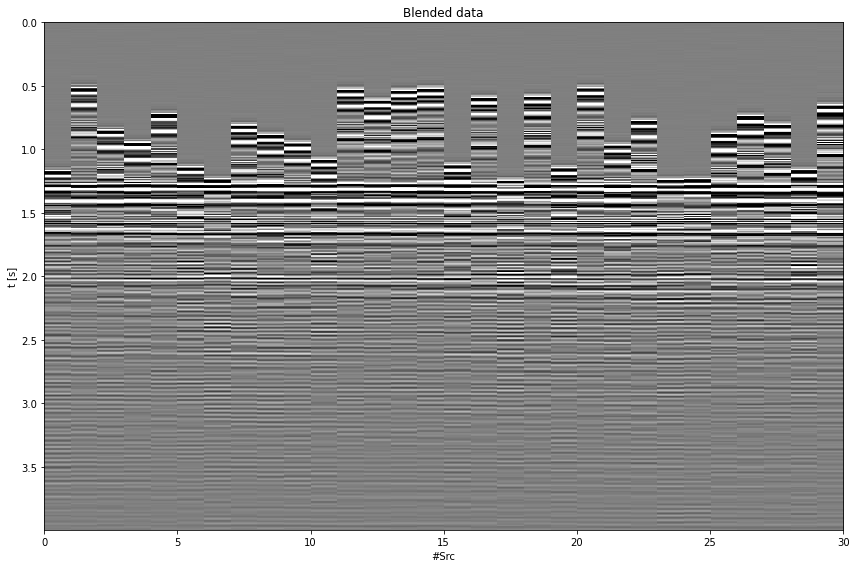

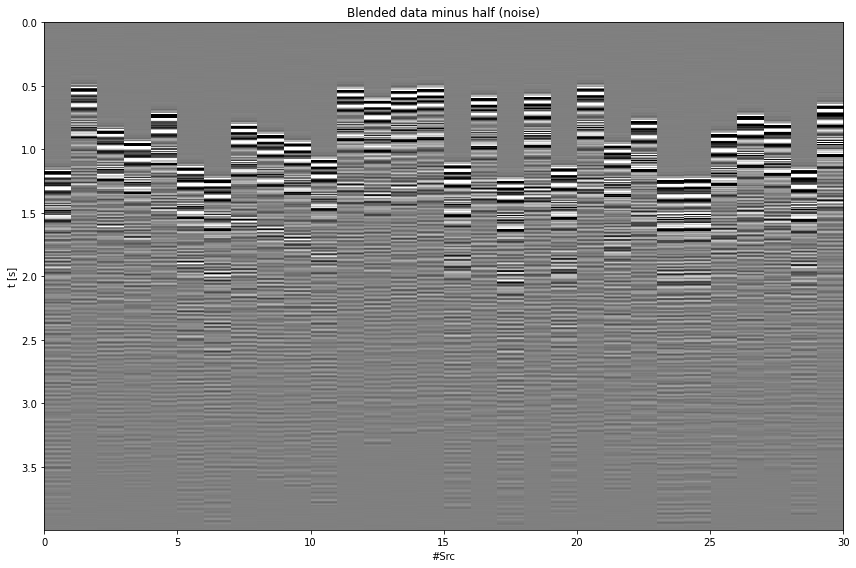

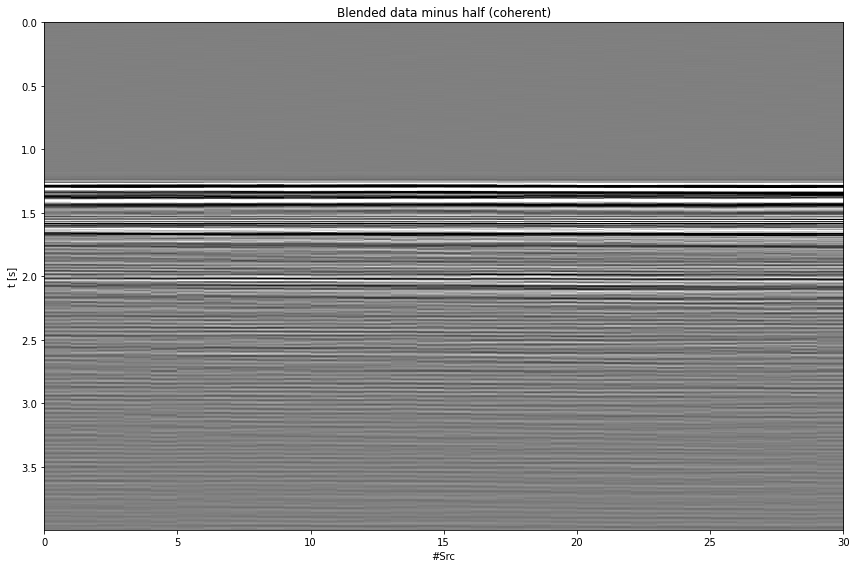

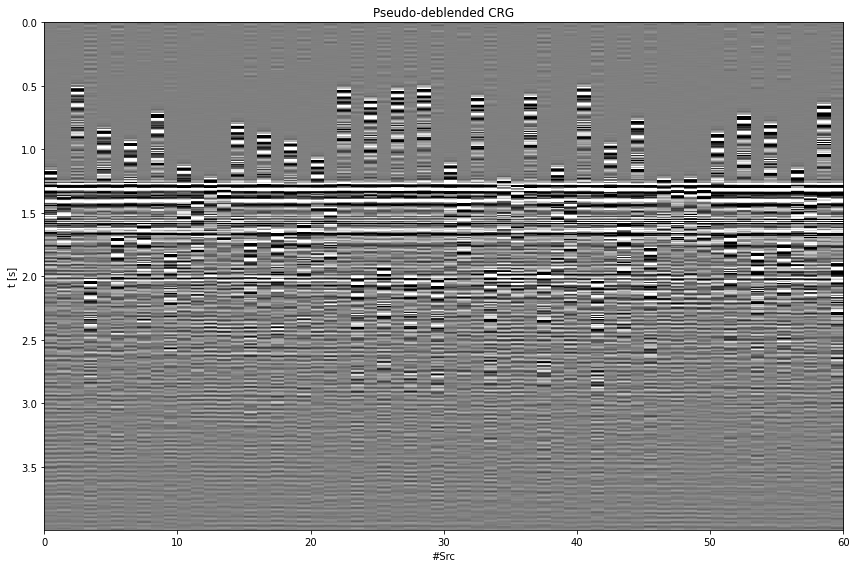

In [9]:
group_size = 2
n_groups = ns//group_size
ignition_times = 0.8*np.random.rand(ns)#-0.2 + 0.4*np.random.rand(ns)
ignition_times[::2] = 0.

Bop = GroupBlending(nt, ns, dt, group_size, n_groups, ignition_times, dtype="complex128")
data_blended = Bop * data.ravel()
data_pseudo = Bop.H * data_blended.ravel()
data_blended = data_blended.reshape(n_groups, nt)
data_blended_minushalf = data_blended - data[::2]
data_pseudo = data_pseudo.reshape(ns, nt)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_blended.T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, n_groups, t[-1], 0),
    interpolation="none",
)
ax.set_title("Blended data")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_blended_minushalf.T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, n_groups, t[-1], 0),
    interpolation="none",
)
ax.set_title("Blended data minus half (noise)")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    (data_blended-data_blended_minushalf).T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, n_groups, t[-1], 0),
    interpolation="none",
)
ax.set_title("Blended data minus half (coherent)")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 30000 rows and 998400 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 60
alpha = 1.410914e-01	thresh = 3.527286e-01
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    5.372e+06   5.992e+06   5.247e+02
     2   -0.00e+00+0.00e+00j    3.968e+06   5.081e+06   4.265e+02
     3   -0.00e+00+0.00e+00j    2.756e+06   4.369e+06   4.476e+02
     4   -0.00e+00+0.00e+00j    1.832e+06   3.903e+06   4.321e+02
     5   -0.00e+00+0.00e+00j    1.190e+06   3.648e+06   3.930e+02
     6   -0.00e+00+0.00e+00j    7.755e+05   3.534e+06   3.425e+02
     7   -0.00e+00+0.00e+00j    5.209e+05   3.490e+06   2.909e+02
     8   -0.00e+00+0.00e+00j    3.686e+05   3.468e+06   2.453e+02
     9   -0.00e+00+0.00e+00j    2.779e+05   3.440e+06   2.094e+02
    10   -0.00

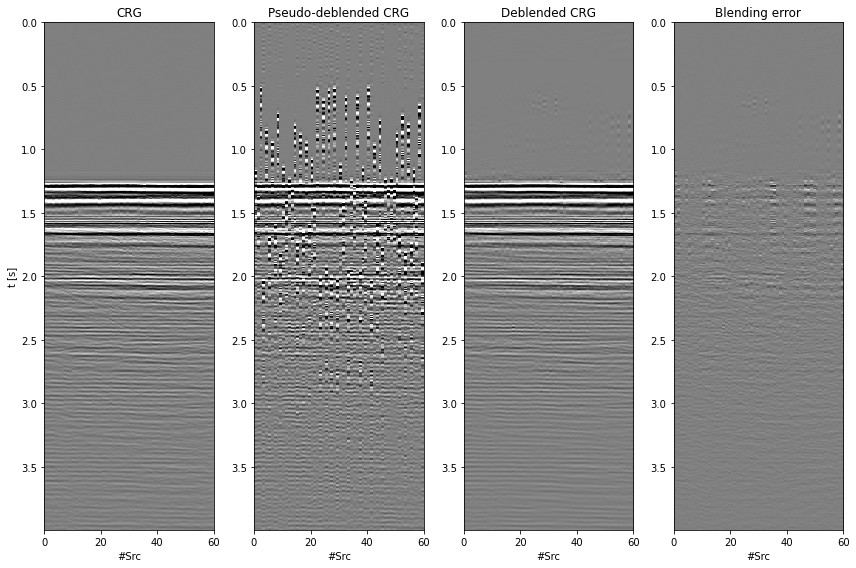

In [10]:
# Patched FK
dimsd = data.shape
nwin = (20, 80)
nover = (10, 40)
nop = (128, 128)
nop1 = (128, 65)
nwins = (5, 24)
dims = (nwins[0] * nop1[0], nwins[1] * nop1[1])

Fop = FFT2D(nwin, nffts=nop, real=True)
Sop = Patch2D(
    Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning", design=False
)
# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 60
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

with pylops.disabled_ndarray_multiplication():
    p_inv = fista(
        Op,
        data_blended.ravel(),
        niter=niter,
        eps=5e0,
        alpha=alpha,
        decay=decay,
        show=True,
    )[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data.T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

## Group blending (3 sources)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 20000 rows and 998400 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 60
alpha = 1.108315e-01	thresh = 2.770787e-01
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    5.034e+06   5.752e+06   5.119e+02
     2   0.00e+00+0.00e+00j    3.491e+06   4.757e+06   3.993e+02
     3   0.00e+00+0.00e+00j    2.251e+06   4.057e+06   4.031e+02
     4   0.00e+00+0.00e+00j    1.382e+06   3.665e+06   3.717e+02
     5   0.00e+00+0.00e+00j    8.329e+05   3.500e+06   3.210e+02
     6   0.00e+00+0.00e+00j    5.118e+05   3.461e+06   2.644e+02
     7   0.00e+00+0.00e+00j    3.332e+05   3.467e+06   2.123e+02
     8   0.00e+00+0.00e+00j    2.358e+05   3.471e+06   1.711e+02
     9   0.00e+00+0.00e+00j    1.825e+05   3.454e+06   1.431e+02
    10   0.00e+00+0.00e

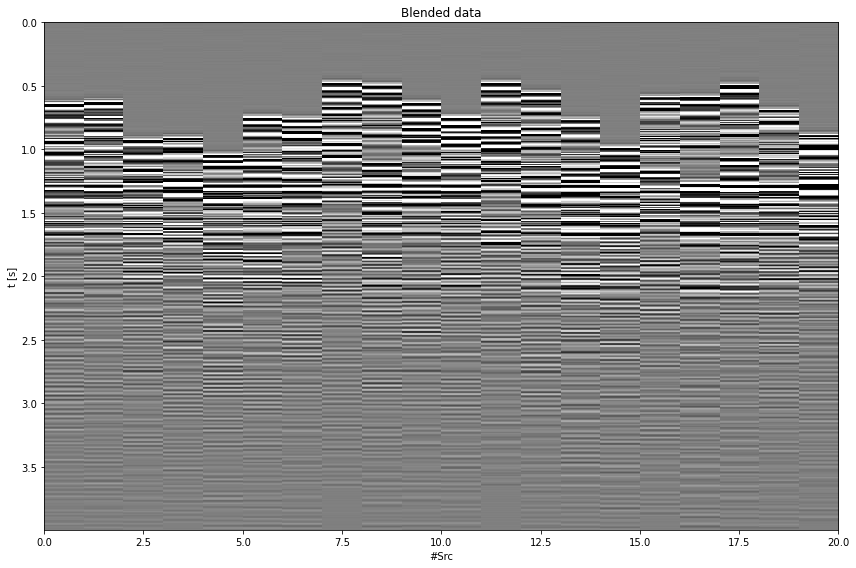

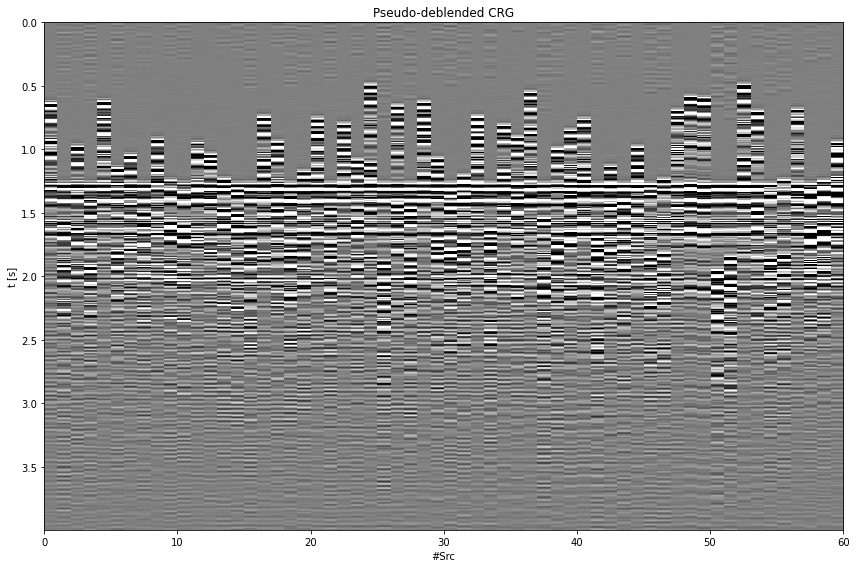

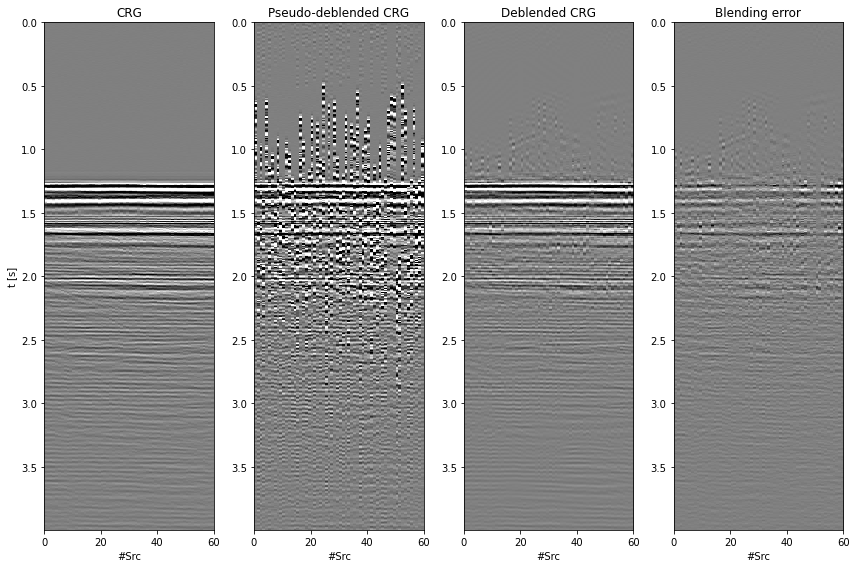

In [11]:
group_size = 3
n_groups = ns//group_size
#ignition_times = -0.2 + 0.4*np.random.rand(ns)
ignition_times = 0.8*np.random.rand(ns)#-0.2 + 0.4*np.random.rand(ns)
ignition_times[::3] = 0.

Bop = GroupBlending(nt, ns, dt, group_size, n_groups, ignition_times, dtype="complex128")
data_blended = Bop * data.ravel()
data_pseudo = Bop.H * data_blended.ravel()
data_blended = data_blended.reshape(n_groups, nt)
data_pseudo = data_pseudo.reshape(ns, nt)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_blended.T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, n_groups, t[-1], 0),
    interpolation="none",
)
ax.set_title("Blended data")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

# Patched FK
dimsd = data.shape
nwin = (20, 80)
nover = (10, 40)
nop = (128, 128)
nop1 = (128, 65)
nwins = (5, 24)
dims = (nwins[0] * nop1[0], nwins[1] * nop1[1])

Fop = FFT2D(nwin, nffts=nop, real=True)
Sop = Patch2D(
    Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning", design=False
)
# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 60
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

with pylops.disabled_ndarray_multiplication():
    p_inv = fista(
        Op,
        data_blended.ravel(),
        niter=niter,
        eps=5e0,
        alpha=alpha,
        decay=decay,
        show=True,
    )[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data.T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

## Half blending 

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 30000 rows and 998400 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 60
alpha = 2.335982e-01	thresh = 5.839956e-01
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    4.218e+06   5.121e+06   9.183e+02
     2   -0.00e+00+0.00e+00j    2.521e+06   4.019e+06   6.243e+02
     3   -0.00e+00+0.00e+00j    1.423e+06   3.433e+06   5.614e+02
     4   -0.00e+00+0.00e+00j    8.044e+05   3.199e+06   4.609e+02
     5   -0.00e+00+0.00e+00j    4.839e+05   3.135e+06   3.587e+02
     6   -0.00e+00+0.00e+00j    3.239e+05   3.121e+06   2.749e+02
     7   -0.00e+00+0.00e+00j    2.436e+05   3.103e+06   2.170e+02
     8   -0.00e+00+0.00e+00j    2.020e+05   3.067e+06   1.828e+02
     9   -0.00e+00+0.00e+00j    1.791e+05   3.019e+06   1.647e+02
    10   -0.00

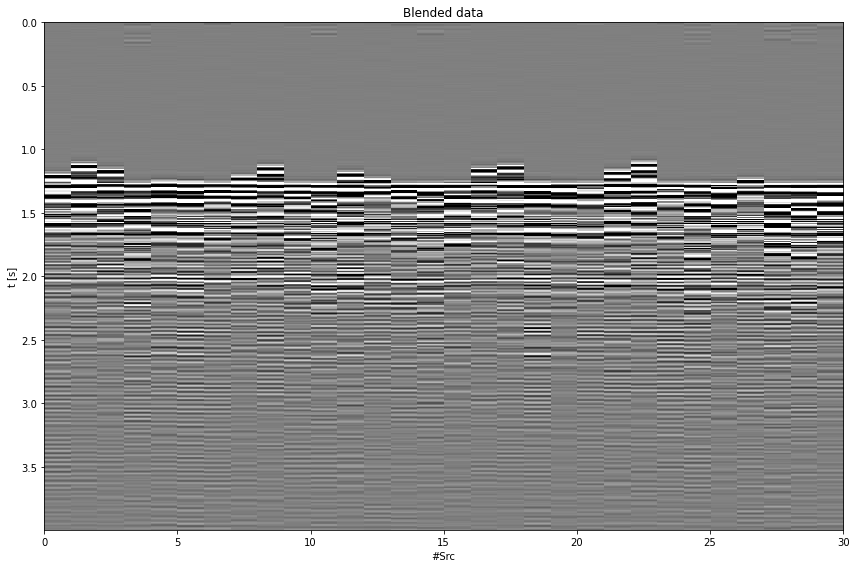

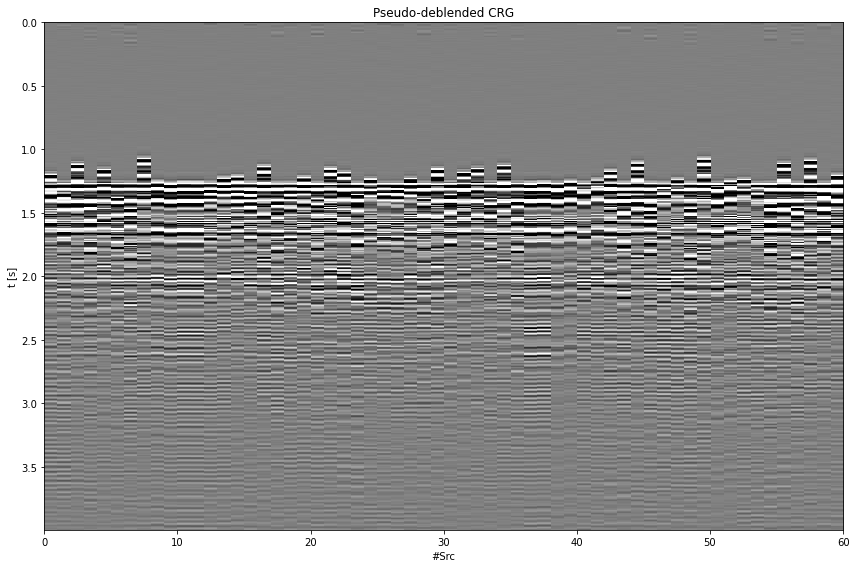

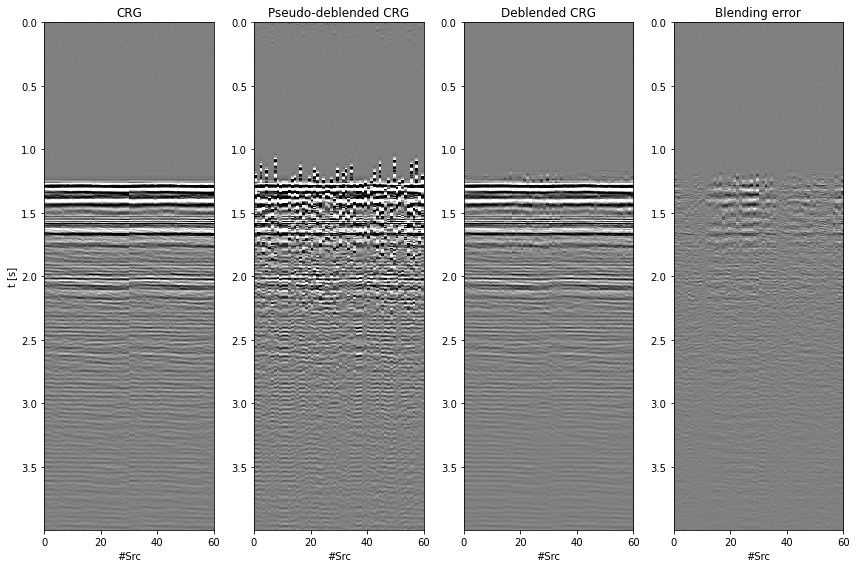

In [21]:
data_half = np.zeros_like(data)
data_half[:ns//2] = data[::2]
data_half[ns//2:] = data[1::2]

group_size = 2
n_groups = ns//group_size
ignition_times = -0.2 + 0.4*np.random.rand(ns)
ignition_times[::2] = 0.

Bop = GroupBlending(nt, ns, dt, group_size, n_groups, ignition_times, dtype="complex128")
data_blended = Bop * data_half.ravel()
data_pseudo = Bop.H * data_blended.ravel()
data_blended = data_blended.reshape(n_groups, nt)
data_pseudo = data_pseudo.reshape(ns, nt)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_blended.T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, n_groups, t[-1], 0),
    interpolation="none",
)
ax.set_title("Blended data")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

# Patched FK
dimsd = data_half.shape
nwin = (20, 80)
nover = (10, 40)
nop = (128, 128)
nop1 = (128, 65)
nwins = (5, 24)
dims = (nwins[0] * nop1[0], nwins[1] * nop1[1])

Fop = FFT2D(nwin, nffts=nop, real=True)
Sop = Patch2D(
    Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning", design=False
)
# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 60
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

with pylops.disabled_ndarray_multiplication():
    p_inv = fista(
        Op,
        data_blended.ravel(),
        niter=niter,
        eps=5e0,
        alpha=alpha,
        decay=decay,
        show=True,
    )[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data_half.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data_half.T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

## TO DO 

- Remake the same for 2 sources at the same time (so that we have 2 codes, one for 1 source and one for N recs)
- Apply the operators to the N recs data to more easily look at blended data and check correctness
- For single source, compute B@B^H